### Maestría: Computación de Alto Desempeño

##### Autor: **Jean Paul Rodríguez**
##### Fecha: **18 de noviembre 2025**
##### Tema: **Técnias de Machine Learning No Supervisado con el ecosistema Apache Spark**

En este notebook se exploran técnicas de Machine Learning no supervisado utilizando PySpark MLlib.
El objetivo principal es crear y evaluar modelos de clustering usando K-means sobre el dataset Iris.

Incluye:

Carga del dataset Iris

Preparación de los datos

Escalamiento

Búsqueda del número óptimo de clusters

Entrenamiento del modelo

Visualización de resultados

<h1>Procesamiento de datos a gran escala</h1>

<p><strong>Objetivo: </strong> El objetivo de este cuaderno es aplicar el algoritmo de clustering a un conjunto de datos sencillos. </p>

<h2>Clustering</h2>

<h2>Indice</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
  <li>Cargar los Datos</li>
  <li>Aplicando Algortimo K-Medias</li>
</ul>

Tiempo estimado: <strong>10 min</strong>

</div>
<hr>

<h3>Cargar los datos</h3>

Para este ejercicio se estará utilizando el conjunto de datos Iris, la cual es una fuente en línea en formato CSV (valores separados por coma).
<p> Este set de datos posee diferentes medidas sobre la planta Iris y es famosamente utilizado como ejemplo en analítica de datos:
  </p>
Se utiliza este conjunto para ejemplificar la creación de clusters:

<ul>
  <li>descripción: <a href="https://archive.ics.uci.edu/ml/datasets/Iris" target="_blank">https://archive.ics.uci.edu/ml/datasets/Iris</a></li>
  <li>fuente de datos: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" target="_blank">https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data</a></li>
    <li>tipo de datos: csv</li>

Se va a utilizar la librería Pandas de Python para realizar la lectura de archivos. Se cargan los datos, se agregan cabeceras y se muestra el resultado:

In [1]:
import findspark

findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

Esta celda configura e inicializa la sesión de Spark.
Se establecen recursos del cluster, el nombre de la aplicación y la URL del master.
Es el punto de partida para poder ejecutar transformaciones y modelos de ML en PySpark.

In [2]:
# Crear sesión 

config = (
    SparkConf()
        .set("spark.scheduler.mode", "FAIR")
        .set("spark.executor.cores", "1")
        .set("spark.executor.memory", "4g")
        .set("spark.cores.max", "4")
        #.setMaster("spark://10.43.100.119:8080")
        .setMaster("spark://10.43.100.119:7077")
    )
config.setAppName("hpcspark_jean")
spark = SparkSession.builder.config(conf=config).getOrCreate()

SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
contextoSpark = spark.sparkContext.getOrCreate()

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/17 19:36:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/17 19:36:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Aquí descargamos el archivo Iris desde su fuente oficial y definimos un schema manualmente para cargarlo como DataFrame de Spark.

Asignamos nombres de columnas y mostramos las primeras filas para verificar que todo se cargó correctamente.

In [3]:
# Leer datos desde archivo CSV
import wget
from pyspark.sql.types import StructType, StructField, FloatType, StringType
url_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
local_path ="./iris.data"
wget.download(url_path,local_path)

schema = StructType([StructField("sepal_length", FloatType(), True),
                     StructField("sepal_width",  FloatType(), True),
                     StructField("petal_length", FloatType(), True),
                     StructField("petal_width",  FloatType(), True),
                     StructField("Species",        StringType(), True)])


df = spark.read.format("csv").option("header", "false").schema(schema).load(local_path)
df.show(5)

-1 / unknown

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



Se imprimen los tipos de datos del DataFrame y se hace un conteo de valores nulos por columna.
Esto asegura que el dataset está limpio y listo para análisis.

In [4]:
df.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)



In [5]:
from pyspark.sql.functions import col, when, isnan, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

[Stage 1:>                                                          (0 + 1) / 1]

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|Species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+




### Aplicar Indexador a Columna "Species"

La columna Species contiene textos, por lo que necesitamos convertirla a valores numéricos

Usamos StringIndexer para mapear cada especie a un número (0, 1, 2)

Esto es útil para exploración.

In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# StringIndexer Initialization
indexer = StringIndexer(inputCol="Species", outputCol="Species_Indexed")
indexerModel = indexer.fit(df)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(df)
indexed_df.show()

[Stage 7:>                                                          (0 + 1) / 1]

+------------+-----------+------------+-----------+-----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|Species_Indexed|
+------------+-----------+------------+-----------+-----------+---------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|            0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|            0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|            0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|            0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|            0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|            0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|            0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.1|         1.5| 

In [7]:
indexed_df.select('Species').distinct().collect()

[Row(Species='Iris-virginica'),
 Row(Species='Iris-setosa'),
 Row(Species='Iris-versicolor')]

<h3>Aplicar Algortimo K-Medias</h3>

Seleccione solo las columnas numéricas:

K-means solo trabaja con variables numéricas

Aquí seleccionamos únicamente las 4 columnas de medidas florales del dataset Iris

In [8]:
df_kmeans = df[["sepal_length","sepal_width","petal_length","petal_width"]]
df_kmeans.show(5)

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows



### Formatear los datos usando Vector Assembler en los vectores los cuales serán usados como "features"

Usamos VectorAssembler para combinar las columnas numéricas en una nueva columna llamada features

PySpark ML necesita esta estructura para entrenar modelos

In [9]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = df_kmeans.columns, outputCol='features')
df_datos = assembler.transform(df)

### Escalar los datos

Escalamos las variables para que tengan media 0 y varianza 1

K-means es sensible a las escalas, y sin normalización los resultados empeoran

In [10]:
from pyspark.ml.feature import StandardScaler

escalador = StandardScaler(
    inputCol="features",
    outputCol="features_scaled",
    withMean=True,
    withStd=True
)

# Compute summary statistics by fitting the StandardScaler
modeloEscalado = escalador.fit(df_datos)

# Normalize each feature to have unit standard deviation.
df_datos = modeloEscalado.transform(df_datos)

df_datos.show(5)

[Stage 15:>                                                         (0 + 1) / 1]

+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|            features|     features_scaled|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.09999990463256...|[-0.8976740030829...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.90000009536743...|[-1.1392003814247...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.69999980926513...|[-1.3807273356108...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|[-1.5014905247816...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.5999999046...|[-1.0184371922538...|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows



### Encontrar el número de clusters usando Silhouette Score

Probamos valores de k entre 2 y 9 y calculamos el Silhouette score para cada uno

Este valor mide qué tan bien separados están los clusters, cuanto más, mejor

Guardamos los resultados para analizarlos luego

In [11]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluador = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='features_scaled', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='features_scaled', k=i)
    KMeans_fit=kmeans.fit(df_datos)
    output = KMeans_fit.transform(df_datos)   
    score = evaluador.evaluate(output)   
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.7714149115179747
Silhouette Score for k = 3 is 0.6542596062597054
Silhouette Score for k = 4 is 0.5906029865156723
Silhouette Score for k = 5 is 0.5813096388431831
Silhouette Score for k = 6 is 0.5305789104210765
Silhouette Score for k = 7 is 0.5192840626174958
Silhouette Score for k = 8 is 0.5344652665341748
Silhouette Score for k = 9 is 0.5355452793639518


### Visualización de silhouette scores

Graficamos los valores obtenidos para ver cómo cambia la calidad del clustering con cada k

Aquí podemos observar visualmente cuál k produce la mejor separación entre grupos

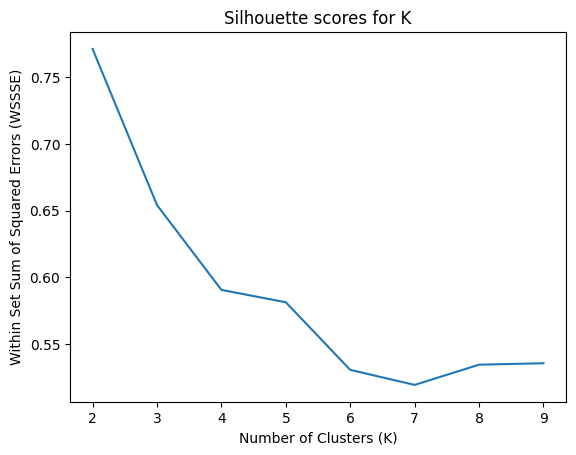

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Silhouette scores for K')
plt.show()

In [13]:
# Método del Codo (Elbow Method)
# Cálculo del Within-Cluster Sum of Squares (WSSSE)

from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

wssse_values = []

for k in range(2, 10):
    kmeans = KMeans(featuresCol="features_scaled", k=k)
    model = kmeans.fit(df_datos)
    predictions = model.transform(df_datos)
    
    # WSSSE = sum of squared distances to cluster centroid
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)

    print(f"k = {k}, WSSSE = {wssse}")

k = 2, WSSSE = 222.24045714435584
k = 3, WSSSE = 190.75692289537915
k = 4, WSSSE = 114.90951861826787
k = 5, WSSSE = 105.83629497321675
k = 6, WSSSE = 81.88142882471757
k = 7, WSSSE = 89.45978739255494
k = 8, WSSSE = 84.19298481233781
k = 9, WSSSE = 56.559987153916694


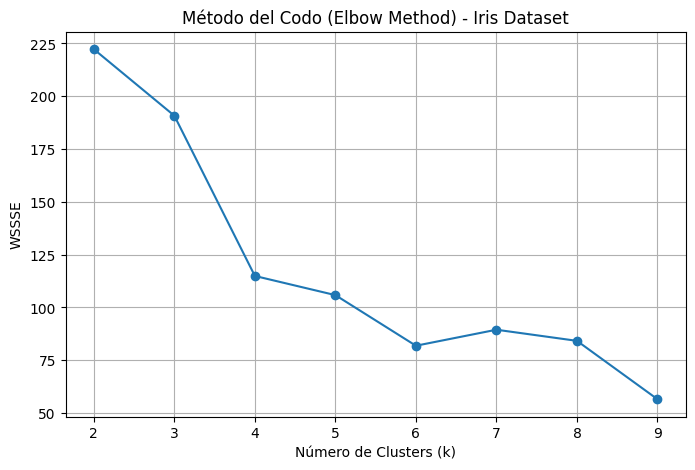

In [14]:
# Gráfica del método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), wssse_values, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WSSSE')
plt.title('Método del Codo (Elbow Method) - Iris Dataset')
plt.grid(True)
plt.show()

¿Cúal k seleccionar? ¿Son satisfactorios los resultados de las diferentes k? 
- Se selecciona k=3 (¿porqué?)
- Compare los resultados para k=4, k=6, k=8

## Análisis de Silhouette y Elbow Method

Basados en el análisis anterior, entrenamos K-means con k=3

La razón es que el Silhouette score muestra buena separación para ese valor, es donde se observa el mayor cambio en el score aumentando de uno a uno los k (comparado con el k anterior)


A partir de los valores obtenidos para WSSSE y Silhouette Score, podemos comparar rápidamente el desempeño de los modelos según el número de clusters k.

**Resultados**

Silhouette más alto: k = 2 (0.77)

Mejor punto de equilibrio: k = 3 (0.65)

Para k ≥ 4, el Silhouette disminuye de forma continua sin ofrecer mejoras claras en la calidad de los clusters

En WSSSE, la caída más significativa ocurre entre k = 2, 3 y 4; después de eso, la reducción es menor, lo que indica el “codo”

## ¿Qué k seleccionar?

Aunque k = 2 tiene el Silhouette más alto, k = 3 es el valor más apropiado porque mantiene una buena separación y coincide con la estructura natural de tres grupos del dataset.
Además, es donde el WSSSE deja de disminuir de forma marcada.



k = 4: Silhouette baja a ~0.58, mejora poco respecto a k=3.

k = 6: Silhouette cae a ~0.49; clusters menos cohesionados.

k = 8: Silhouette ~0.47; clara sobre-partición.

Los cambios de Silhouette entre estos valores son pequeños comparados con la diferencia entre k=2 y k=3, por lo que no justifican más clusters

## Conclusión

El valor óptimo es k = 3, pues mantiene buena separación, suficiente compactación y representa la estructura real del dataset sin sobre-dividir los grupos

### Entrenar el modelo

In [15]:
kmeans = KMeans(k=3, featuresCol="features_scaled", predictionCol="cluster")
kmeans_model = kmeans.fit(df_datos)

### Evaluar el modelo k=3 Within Set Sum of Squared Errors (WSSSE) metric

Se calcula el WSSSE del modelo entrenado

Este valor indica qué tan compactos son los clusters: mientras menor, mejor

In [16]:
output = KMeans_fit.transform(df_datos)
wssse = evaluador.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5355452793639518


### Visualizar los Datos

In [17]:
clustered_data = kmeans_model.transform(df_datos)

## Conversión a Pandas y visualización básica

Convertimos el DataFrame de salida a pandas y generamos una visualización simple con Matplotlib para ver la distribución de clusters.

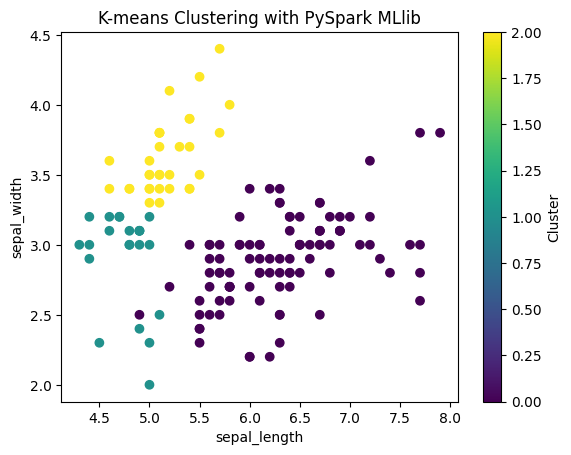

In [18]:
# Converting to Pandas DataFrame
clustered_data_pd = clustered_data.toPandas()

# Visualizing the results
plt.scatter(clustered_data_pd["sepal_length"], clustered_data_pd["sepal_width"], c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

In [19]:
df_datos.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'Species',
 'features',
 'features_scaled']

## Visualización con Matplotlib (petal_length vs petal_width)

Aquí graficamos usando colores por cluster

Estas dos variables son con diferencia las que muestran mejor separación en el dataset Iris, así que se ve muy clara la segmentación

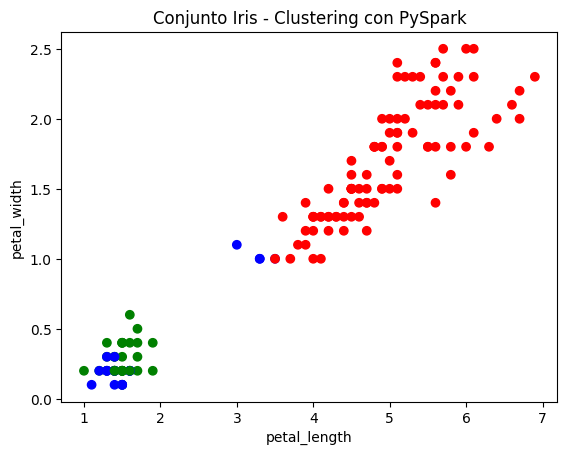

In [20]:
#Visualizando con Matplotlib
import matplotlib.pyplot as plt
import numpy as np
colors = np.array(["red", "blue", "green", "cyan", "yellow"])

plt.scatter(
    clustered_data_pd["petal_length"],
    clustered_data_pd["petal_width"],
    c=colors[clustered_data_pd["cluster"]]
)

plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.title("Conjunto Iris - Clustering con PySpark")
plt.show()

## Visualización con Matplotlib (sepal_length vs sepal_width)

Otra visualización, esta vez con las variables del sépalo

Normalmente estas variables separan peor las especies, así que el gráfico ayuda a ver esa diferencia

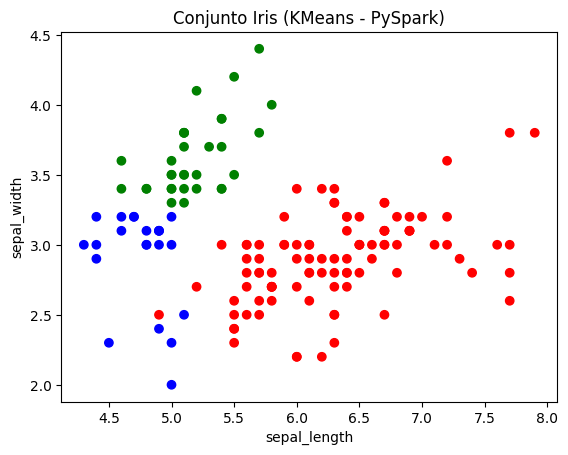

In [21]:
#Visualizando con Matplotlib
colors = np.array(['red', 'blue', 'green', 'cyan', 'yellow'])

plt.scatter(
    clustered_data_pd["sepal_length"],
    clustered_data_pd["sepal_width"],
    c=colors[clustered_data_pd["cluster"]]
)

plt.title("Conjunto Iris (KMeans - PySpark)")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.show()

## Visualización con Seaborn

Creamos otro scatterplot usando seaborn, con una figura más estilizada 

Esto complementa las visualizaciones anteriores y permite ver patrones más limpios

In [22]:
!pip install seaborn

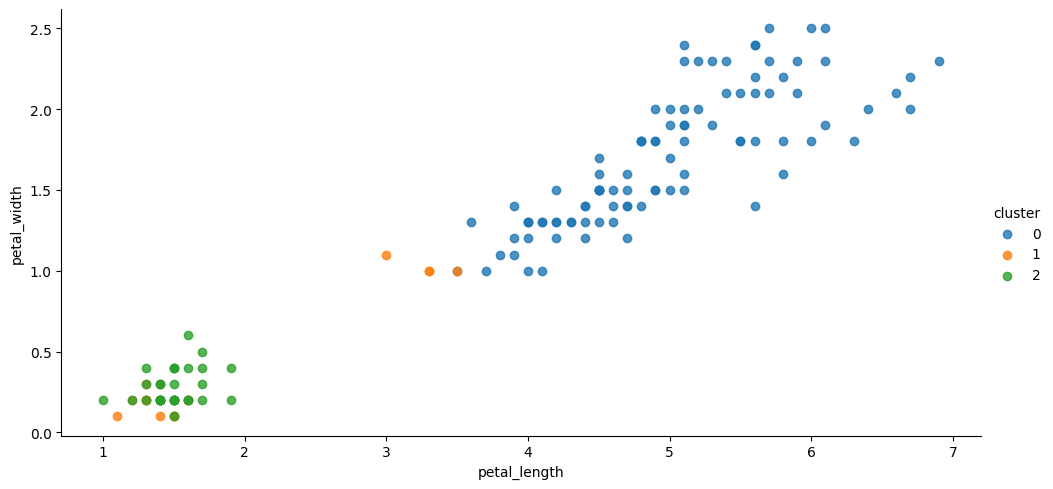

In [23]:
import seaborn as sns

sns.lmplot(
    x='petal_length',
    y='petal_width',
    data=clustered_data_pd,
    hue='cluster',
    fit_reg=False,
    height=5,
    aspect=2
)

## Resumen / Conclusión

En este notebbok:

Se cargó y preparó el dataset Iris con PySpark

Se escalaron las variables numéricas

Se probó K-means con distintos valores de k

Se evaluó cada modelo usando Silhouette Score

Se concluyó que k = 3 tiene el mejor score

Se visualizaron los clusters para verificar su separación

Las variables de pétalo mostraron una clara división entre grupos

Las variables de sépalo no separan tan bien

El modelo con k=3 captura adecuadamente la estructura real del dataset

En general, el clustering funcionó bien y confirma la conocida estructura de 3 grupos del dataset Iris.